In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.losses import Loss
import time 
# from tensorflow.keras.applications import *
# from matplotlib import plotly as plt
import matplotlib.pyplot as plt
import numpy as np

(30000, 56, 28)
(30000, 2)


2022-06-28 13:05:58.980207: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-28 13:05:59.636377: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9651 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:d8:00.0, compute capability: 7.5


(5000, 56, 28, 1)
(5000, 2)
(56, 28, 1)


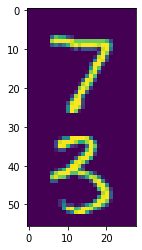

tf.Tensor(
[[7. 3.]
 [2. 9.]
 [1. 9.]
 ...
 [2. 4.]
 [4. 5.]
 [0. 6.]], shape=(5000, 2), dtype=float32)


In [2]:
batch_size = 32
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

N = x_train.shape[0] // 2
x_train = np.concatenate((x_train[:N], x_train[N:]), axis=1)
y_train = np.stack((y_train[:N], y_train[N:]), axis=1)
# y_train = tf.ones(y_train.shape)
N = x_test.shape[0] // 2

x_test = np.concatenate((x_test[:N], x_test[N:]), axis=1)
y_test = np.stack((y_test[:N], y_test[N:]), axis=1)
# y_test = tf.ones(y_test.shape)
print(x_train.shape)
print(y_train.shape)


input_shape = x_train[0].shape

x_train = tf.convert_to_tensor(x_train, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
x_test = tf.convert_to_tensor(x_test, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

x_test = tf.expand_dims(x_test, -1)
x_train = tf.expand_dims(x_train, -1)
print(x_test.shape)
print(y_test.shape)

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

# Prepare the validation dataset.
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(batch_size)

input_shape = x_test[0].shape
num_classes = 10
print(input_shape)

plt.figure()
plt.imshow(x_test[0, :, :, 0]) 
plt.show()
print(y_test)

In [8]:

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(50, activation="relu"),
        layers.Dense(2*num_classes, activation=None),
    ]
)

model.summary()


optimizer = tf.keras.optimizers.Adam(0.001)

cce_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# loss_fn = cce_loss
def loss_fn(y, y_hat): 
#     print(y[:, 0], y_hat[:, :10])
    return cce_loss(y[:, 0], y_hat[:, :10]) + cce_loss(y[:, 1], y_hat[:, 10:])

#         cce_loss(y_batch_train[:, 0], logits[:, :10]) + cce_loss(y_batch_train[:, 0], logits[:, 10:])



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 54, 26, 64)        640       
                                                                 
 conv2d_5 (Conv2D)           (None, 52, 24, 64)        36928     
                                                                 
 conv2d_6 (Conv2D)           (None, 50, 22, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 25, 11, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 23, 9, 32)         9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 11, 4, 32)        0         
 2D)                                                  

In [9]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=loss_fn
)

model.fit(
    train_dataset,
    epochs=6,
    validation_data=test_dataset,
)

Epoch 1/6
938/938 [==============================] - 10s 10ms/step - loss: 0.7973 - val_loss: 0.2008
Epoch 2/6
938/938 [==============================] - 9s 9ms/step - loss: 0.1669 - val_loss: 0.1340
Epoch 3/6
938/938 [==============================] - 9s 9ms/step - loss: 0.1186 - val_loss: 0.1126
Epoch 4/6
938/938 [==============================] - 9s 9ms/step - loss: 0.0955 - val_loss: 0.1230
Epoch 5/6
938/938 [==============================] - 9s 9ms/step - loss: 0.0809 - val_loss: 0.1252
Epoch 6/6
938/938 [==============================] - 9s 9ms/step - loss: 0.0701 - val_loss: 0.1057


In [6]:
model.layers[0].name

'conv2d'

In [ ]:
n = 100

jac_dict = {}

"""
set up as:
{
  "layer_0": [[derivative vector for point 0 wrt L_d1], [derivative vector for point 0 wrt L_d2], 
  ..., [derivative vector for point n wrt L_d1], [derivative vector for point n wrt L_d2]],
.
.
.
{
  "layer_k": [[derivative vector for point 0 wrt L_d1], [derivative vector for point 0 wrt L_d2], 
  ..., [derivative vector for point n wrt L_d1], [derivative vector for point n wrt L_d2]]
} 
"""
def pointwise_cce_loss(y, logits): 
    loss1 = np.zeros(logits.shape[0])
    loss2 = np.zeros(logits.shape[0])

    for i in range(logits.shape[0]): 
        cce_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        cce_loss2 = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        loss1[i] = cce_loss(y[i:i+1, 0], logits[i:i+1, :10])
        loss2[i] = cce_loss2(y[:, 1], logits[:, 10:])
#         print(loss1[i])
    loss = tf.convert_to_tensor([loss1, loss2])
    print(loss)
    return loss

def jacobian_f(weights, layer_name): 
    print(f'layer_name: {layer_name}')
#     print(f'weighst: {weights}')
    x = x_test[0:n]
    y = y_test[0:n]
    with tf.GradientTape() as t:

        logits = model(x) 
#         loss = pointwise_cce_loss(y, logits)
        loss1 = []
        loss2 = []

        for i in range(logits.shape[0]): 
            cce_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
            cce_loss2 = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
            loss1.append(cce_loss(y[i:i+1, 0], logits[i:i+1, :10]))
            loss2.append(cce_loss2(y[:, 1], logits[:, 10:]))
    #         print(loss1[i])
        loss = tf.convert_to_tensor(loss1 + loss2)

    jac = t.jacobian(loss, weights)

#     print(jac)
    jac_dict[name].append(jac[0]) #throw out the biases info
#         jac_dict[name].append([tf.reshape(jac1[0], (-1, jac1[0].shape[-1])), tf.reshape(jac2[0], (-1, jac1[0].shape[-1]))])

#         if jac1 != None: 
#             print(jac1[0].shape)
#             print(tf.reshape(jac1[0], (-1, jac1[0].shape[-1])).shape)

for layer in model.layers: 
    name = layer.name 
    weights = layer.trainable_weights
    if weights != []:
        jac_dict[name] = []
        jacobian_f(weights, name)
        
        
        

layer_name: conv2d_4


2022-06-28 13:09:53.714345: W tensorflow/core/common_runtime/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.62GiB (rounded to 2816000000)requested by op gradient_tape/MaxPoolGrad_1/pfor/Tile
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2022-06-28 13:09:53.714969: I tensorflow/core/common_runtime/bfc_allocator.cc:1027] BFCAllocator dump for GPU_0_bfc
2022-06-28 13:09:53.715020: I tensorflow/core/common_runtime/bfc_allocator.cc:1034] Bin (256): 	Total Chunks: 2152, Chunks in use: 2051. 538.0KiB allocated for chunks. 512.8KiB in use in bin. 25.4KiB client-requested in use in bin.
2022-06-28 13:09:53.715052: I tensorflow/core/common_runtime/bfc_allocator.cc:1034] Bin (512): 	Total Chunks: 306, Chunks in use: 200. 153.0KiB allocated for chunks. 100.0KiB in use in bin. 78.1KiB client-requested in u

In [ ]:
from sklearn.manifold import TSNE


In [ ]:


for layer in jac_dict.keys(): 
    grads = jac_dict[layer]
#     print(grads)
#     break
    X = np.array(grads)
    print(X.shape)
    X = X.reshape(n, 2, -1)
    X = X.reshape(n*2, -1)
    Y = y_test[:n].numpy().reshape(-1).astype(np.int32)

    X_embedded = TSNE(n_components=2, learning_rate='auto', init='pca').fit_transform(X)
    
    labels = [i % 2 for i in range(2*n)]
    plt.figure()
    plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c = labels)
#     for i in range(X_embedded.shape[0]):
#         plt.text(X_embedded[i,0], X_embedded[i,1], str(Y[i]))
#     plt.savefig(f'{layer}')
    plt.show()
